Bootstrapping

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_6464\4152930474.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
data = pd.read_csv("../data/cookie_cats.csv")
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [5]:
gate_30 = data[data.version == 'gate_30']
gate_40 = data[data.version == 'gate_40']

В теме 1 мы избавлялись от выбросов в датасете и анализировали разницу средних. Если возможности избавиться от выбросов нет, более подходящей метрикой будет медиана. Если в случае средних мы могли сказать, что по ЦПТ распределения средних нормальны (и мы можем использовать t-test), для медиан это неверно. Как мы можем оценить распределение этого и других параметров?

По существующей выборке (генеральной совокупности) берём подвыборки:

In [21]:
def bootstrap_median(dataframe, column, iters, name):
    boot_data = []
    for i in tqdm(range(iters)):
        # Важно: одно значение исходной выборки может попадать в подвыборку несколько раз,
        # на любой итерации создания подвыборки у всех элементов ГС одинаковая вероятность быть выбранными
        # (сэмплирование с возвращением)
        # Размер каждой подвыборки равен размеру исходной.
        boot_median = dataframe.sample(frac = 1, replace = True)[column].median()
        boot_data.append(boot_median)
    return pd.DataFrame(boot_data, columns=[name])

iterations = 2000
boot_30_sum_median = bootstrap_median(gate_30, 'sum_gamerounds', iterations, 'gate_30')
boot_40_sum_median = bootstrap_median(gate_40, 'sum_gamerounds', iterations, 'gate_40')
boot_sum_median = boot_30_sum_median.merge(boot_40_sum_median, left_index=True, right_index=True)

100%|██████████| 2000/2000 [02:18<00:00, 14.44it/s]


Получили набор медиан, среднее по медианам подвыборок близко к медиане ГС.

In [22]:
print('Gate 30. Original median:', gate_30['sum_gamerounds'].median())
print('Gate 30. Bootstrap median:', boot_sum_median['gate_30'].mean())
print('Gate 40. Original median:', gate_40['sum_gamerounds'].median())
print('Gate 30. Bootstrap median:', boot_sum_median['gate_40'].mean())

Gate 30. Original median: 17.0
Gate 30. Bootstrap median: 16.95625
Gate 40. Original median: 16.0
Gate 30. Bootstrap median: 16.026


Теперь можно оценить распределения медиан.

In [16]:
boot_40_sum_median.value_counts()

gate_40
16.0       1953
17.0         47
Name: count, dtype: int64

In [17]:
boot_30_sum_median.value_counts()

gate_30
17.0       1913
16.0         86
16.5          1
Name: count, dtype: int64

Ещё раз убедимся, что распределение средних близко к нормальному (делали это для `sum_gamerounds`, посмотрим на `retention_7`):

In [28]:
def bootstrap_mean(dataframe, column, iters, name):
    boot_data = []
    for i in tqdm(range(iters)):
        boot_mean = dataframe.sample(frac = 1, replace = True)[column].mean()
        boot_data.append(boot_mean)
    return pd.DataFrame(boot_data, columns=[name])

iterations = 3000
boot_30_ret_mean = bootstrap_mean(gate_30, 'retention_7', iterations, 'gate_30')
boot_40_ret_mean = bootstrap_mean(gate_40, 'retention_7', iterations, 'gate_40')
boot_ret_mean = boot_30_ret_mean.merge(boot_40_ret_mean, left_index=True, right_index=True)

100%|██████████| 3000/3000 [00:25<00:00, 117.61it/s]


<Axes: ylabel='Frequency'>

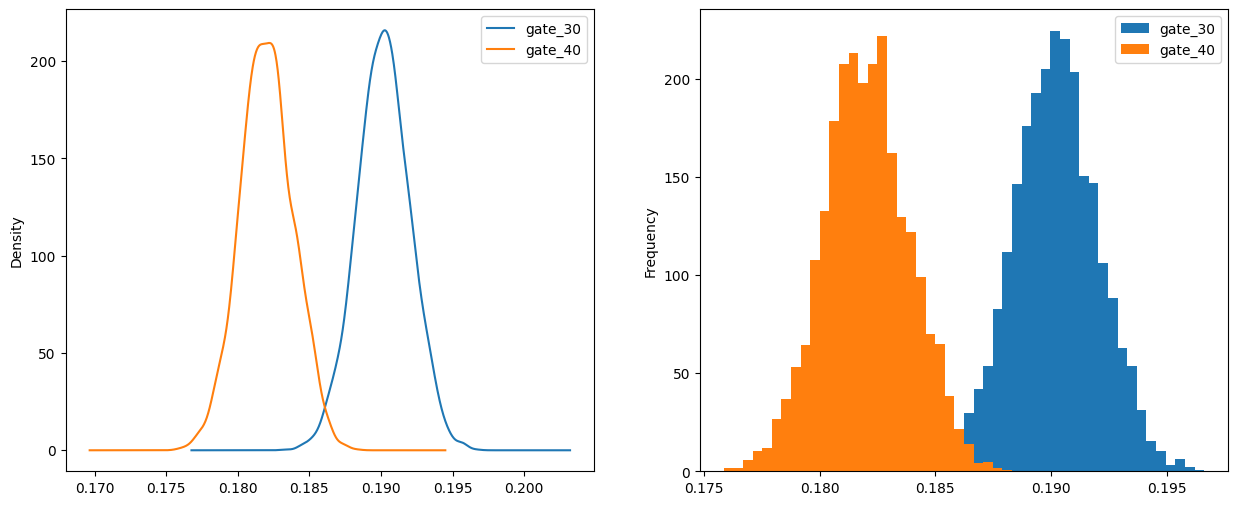

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
boot_ret_mean[["gate_30", "gate_40"]].plot(kind='density', xlabel='means', ax=ax1)
boot_ret_mean[["gate_30", "gate_40"]].plot(kind='hist', bins=50, density=True, ax=ax2)

100%|██████████| 300/300 [00:00<00:00, 387.16it/s]


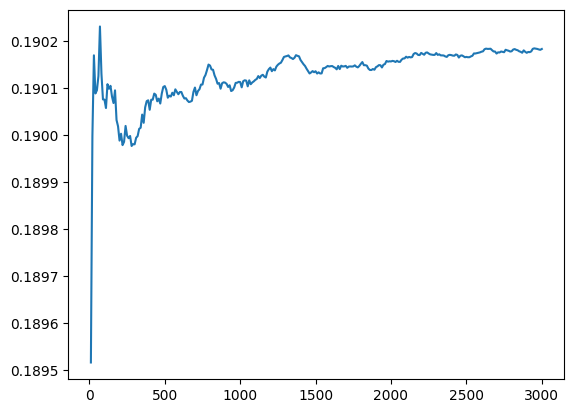

In [30]:
sizes = []
means = []

size = 0
for i in tqdm(range(len(boot_30_ret_mean) // 10)):
    size += 10
    sizes.append(size)
    means.append(boot_30_ret_mean[:size].mean())

plt.plot(sizes, means)
plt.show()

Коррекция смещения (bias correction)

In [ ]:
def bootstrap_median(dataframe, column, iters, name):
    boot_data = []
    for i in range(iters):
        boot_mean = dataframe.sample(frac = 1, replace = True)[column].median()
        boot_data.append(boot_mean)
    return pd.DataFrame(boot_data, columns=[name])

iterations = 2000
boot_30_median = bootstrap_median(gate_30, 'sum_gamerounds', iterations, 'gate_30')
boot_40_median = bootstrap_median(gate_40, 'sum_gamerounds', iterations, 'gate_40')
boot = boot_30_median.merge(boot_40_median, left_index=True, right_index=True)
boot['diff'] = boot['gate_30'] - boot['gate_40']

In [33]:
orig_theta_ret = np.mean(gate_30['retention_7'])
boot_theta_ret = np.mean(boot_30_ret_mean)
delta_val_ret = boot_theta_ret - orig_theta_ret
orig_theta_ret, boot_theta_ret, delta_val_ret

(0.19020134228187918, 0.19018354213273675, -1.7800149142432886e-05)

In [49]:
ret_boot_corrected = [i - delta_val_ret for i in boot_30_ret_mean['gate_30']]

In [60]:
print('Before correction:\t', boot_30_ret_mean['gate_30'].mean())
print('After correction:\t', np.mean(ret_boot_corrected))
print('Original mean:\t\t', gate_30['retention_7'].mean())

Before correction:	 0.19018354213273675
After correction:	 0.19020134228187918
Original mean:		 0.19020134228187918


<Axes: ylabel='Density'>

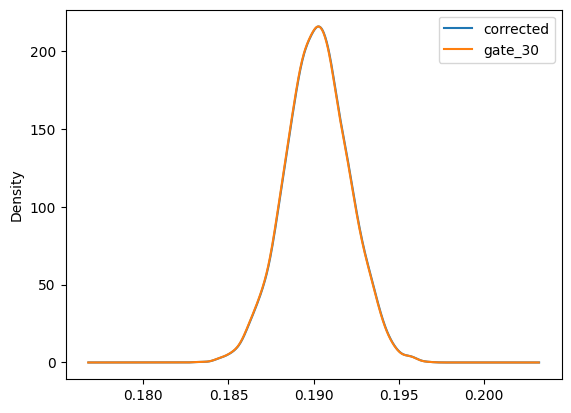

In [61]:
pd.DataFrame(ret_boot_corrected, columns=['corrected']).merge(
    boot_30_ret_mean, left_index=True, right_index=True)

Более заметна коррекция на медианах:

In [40]:
orig_theta_sum = np.median(gate_30['sum_gamerounds'])
boot_theta_sum = np.mean(boot_30_sum_median)
delta_val_sum = boot_theta_sum - orig_theta_sum
orig_theta_sum, boot_theta_sum, delta_val_sum

(17.0, 16.95625, -0.04374999999999929)

In [46]:
sum_boot_corrected = [i - delta_val_sum for i in boot_30_sum_median['gate_30']]

In [58]:
print('Before correction:\t', boot_sum_median['gate_30'].mean())
print('After correction:\t', np.mean(sum_boot_corrected))
print('Original median:\t', gate_30['sum_gamerounds'].median())

Before correction:	 16.95625
After correction:	 16.999999999999993
Original median:	 17.0


<Axes: ylabel='Density'>

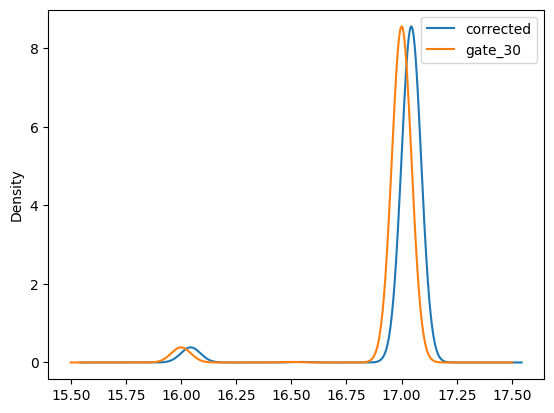

In [62]:
pd.DataFrame(sum_boot_corrected, columns=['corrected']).merge(
    boot_30_sum_median, left_index=True, right_index=True).plot(kind='density')

### Проверка гипотезы

Для проверки гипотезы проводим бутстрап по двум группам и сохраняем разности. Также корректируем смещение.

In [90]:
boot_data = []

for _ in tqdm(range(iterations)):
    boot_30 = gate_30.sample(frac = 1, replace = True)['retention_7'].mean()
    boot_40 = gate_40.sample(frac = 1, replace = True)['retention_7'].mean()
    boot_data.append(boot_30 - boot_40)

orig_theta = gate_30['retention_7'].mean() - gate_40['retention_7'].mean()
boot_theta = np.mean(boot_data)
delta_val = orig_theta - boot_theta
boot_corrected_plus = [i + delta_val for i in boot_data]
boot_corrected_minus = [i - delta_val for i in boot_data]
boot_corrected = boot_corrected_plus if (
    abs(np.mean(boot_corrected_plus) - orig_theta) < abs(np.mean(boot_corrected_minus) - orig_theta)) else boot_corrected_minus

100%|██████████| 3000/3000 [01:28<00:00, 34.05it/s]


In [91]:
np.mean(boot_corrected), orig_theta

(0.008201298315205911, 0.008201298315205913)

In [92]:
alpha = 0.05

mean = np.mean(boot_corrected)
std = np.std(boot_corrected)
p_1 = norm.cdf(x=0, loc=mean, scale=std)
p_2 = norm.cdf(x=0, loc=-mean, scale=std)
p_value = min(p_1, p_2) * 2
p_value, p_value < alpha

(0.0016533658434252463, True)

In [20]:
import plotly.express as px
df = px.data.tips()
fig = px.ecdf(pd.DataFrame(boot_corrected))
fig.add_vline(x=p_value)
fig.show()

Для распределения параметра мы можем построить доверительный интервал, куда с заданной $1 - \alpha$ вероятностью попадают значения бутстрап-выборки.

In [84]:
left_ci = alpha / 2
right_ci = 1 - alpha / 2
pd.DataFrame(boot_corrected).quantile([left_ci, right_ci])

,0
0.025,0.003112
0.975,0.013238


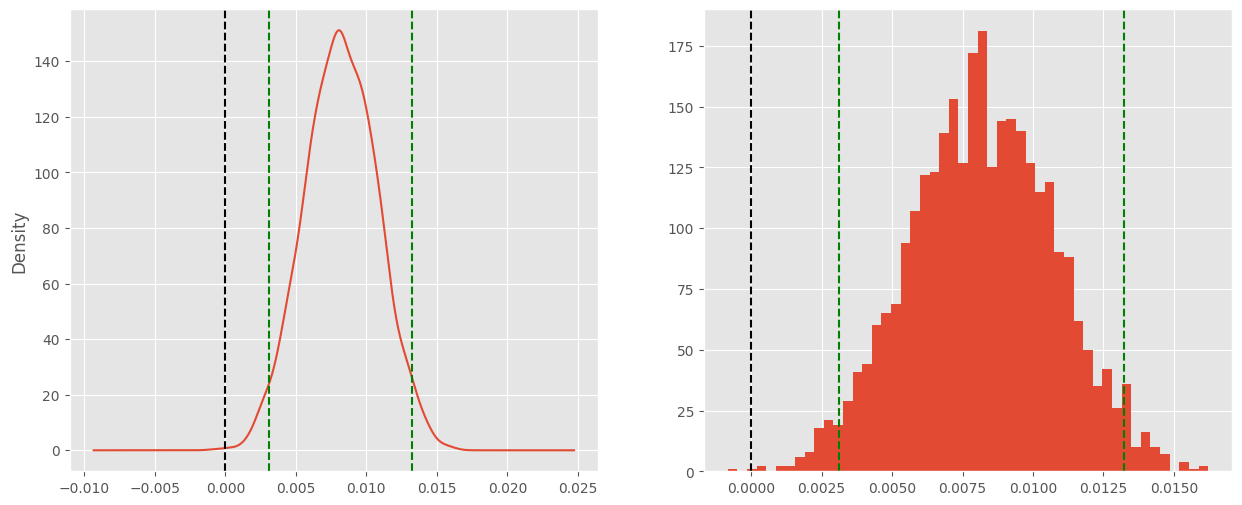

In [89]:
sr = pd.Series(boot_corrected)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
sr.plot(kind='density', ax=ax1)
ax1.axvline(x=0, color='black', linestyle='--')
ax1.axvline(x=sr.quantile(left_ci), color='green', linestyle='--')
ax1.axvline(x=sr.quantile(right_ci), color='green', linestyle='--')

ax2.hist(sr, bins = 50)
ax2.axvline(x=0, color='black', linestyle='--')
ax2.axvline(x=sr.quantile(left_ci), color='green', linestyle='--')
ax2.axvline(x=sr.quantile(right_ci), color='green', linestyle='--')

0 за пределами доверительного интервала, то есть, мы можем отвергнуть нулевую гипотезу.

! Нельзя после бутстрапа использовать критерии, требующие независимости данных

## Ratio-метрики

In [2]:
conversion_data = pd.read_csv('../data/KAG_conversion_data.csv')
conversion_data

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.430000,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.820000,2,0
2,708771,916,103920,30-34,M,20,693,0,0.000000,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.250000,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.290000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1138,1314410,1178,179977,45-49,F,109,1129773,252,358.189997,13,2
1139,1314411,1178,179978,45-49,F,110,637549,120,173.880003,3,0
1140,1314412,1178,179979,45-49,F,111,151531,28,40.289999,2,0
1141,1314414,1178,179981,45-49,F,113,790253,135,198.710001,8,2


Ratio-метрика — отношение двух случайных величин, часто зависимых.<br>
Пример: CTR (Click Through Rate)

In [8]:
conversion_data['CTR'] = conversion_data['Clicks'] / conversion_data['Impressions']
conversion_data[['Clicks', 'Impressions', 'CTR']]

,Clicks,Impressions,CTR
0,1,7350,0.000136
1,2,17861,0.000112
2,0,693,0.000000
3,1,4259,0.000235
4,1,4133,0.000242
...,...,...,...
1138,252,1129773,0.000223
1139,120,637549,0.000188
1140,28,151531,0.000185
1141,135,790253,0.000171


Наивный способ подсчёта CTR: $$\frac{\frac{Clicks_1}{Impressions_1} + ... + \frac{Clicks_n}{Impressions_n}}{n}$$

In [5]:
n = conversion_data.shape[0]
ctr_n = conversion_data['CTR'].sum() / n
print('Naive CTR:\t', ctr_n)

Naive CTR:	 0.00016419671305996467


Наивный CTR не учитывает вес ($\frac{1}{10} = \frac{1000}{10000}$), результат будет смещён.<br>
Глобальный CTR: $$\frac{Clicks_1 + ... + Clicks_n}{Impressions_1 + ... + Impressions_n}$$

In [6]:
ctr_g = conversion_data['Clicks'].sum() / conversion_data['Impressions'].sum()
bias = ctr_g - ctr_n
print('Global CTR:\t', ctr_g)
print('Bias:\t\t', bias)

Global CTR:	 0.00017881336592357833
Bias:		 1.4616652863613658e-05


In [4]:
conversion_data.age.unique()

array(['30-34', '35-39', '40-44', '45-49'], dtype=object)

Сравним CTR двух возрасных групп. Мы не можем использовать критерии, требующие независимости данных.

In [9]:
from scipy.stats import mannwhitneyu

group_A = conversion_data[conversion_data['age'].isin(['30-34', '35-39'])]
group_B = conversion_data[conversion_data['age'].isin(['40-44', '45-49'])]
mannwhitneyu(group_A['CTR'], group_B['CTR'], alternative='two-sided').pvalue

4.634899794567663e-35

Для ratio-метрик можно использовать бутстрап.

In [8]:
iterations = 10000
ctr_A = group_A.Clicks.sum() / group_A.Impressions.sum()
ctr_B = group_B.Clicks.sum() / group_B.Impressions.sum()
ctr_delta = abs(ctr_A - ctr_B)
result = []

for i in tqdm(range(iterations)):
    sample_A = group_A.sample(frac = 1, replace = True)
    sample_B = group_B.sample(frac = 1, replace = True)
    ctr_boot_A = sample_A.Clicks.sum() / sample_A.Impressions.sum()
    ctr_boot_B = sample_B.Clicks.sum() / sample_B.Impressions.sum()
    result.append(ctr_boot_B - ctr_boot_A)

100%|██████████| 10000/10000 [01:07<00:00, 147.81it/s]


In [13]:
alpha = 0.05
result_series = pd.Series(result)

B_global_ctr = group_B['Clicks'].sum() / group_B['Impressions'].sum()
A_global_ctr = group_A['Clicks'].sum() / group_A['Impressions'].sum()
print('Global CTR:\t\t', (B_global_ctr - A_global_ctr))
print('Bootstrap CTR:\t\t', result_series.mean())
print('Bias:\t\t\t', result_series.mean() - (B_global_ctr - A_global_ctr))

print()
left_ci = np.quantile(result_series, alpha / 2)
right_ci = np.quantile(result_series, 1 - alpha / 2)
print('Доверительный инетрвал:\t', left_ci, right_ci)
print('Стандартная ошибка:\t', result_series.std())

Global CTR:		 5.834206219780682e-05
Bootstrap CTR:		 5.837424962083776e-05
Bias:			 3.218742303094137e-08

Доверительный инетрвал:	 4.9001039500498454e-05 6.774924490911616e-05
Стандартная ошибка:	 4.773603803879295e-06


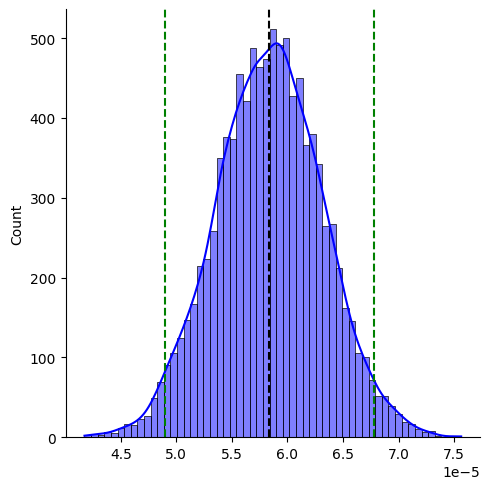

In [23]:
sns.displot(result_series, kde=True, color='blue')
plt.axvline(result_series.mean(), color='black', linestyle='--')
plt.axvline(x=left_ci, color='green', linestyle='--')
plt.axvline(x=right_ci, color='green', linestyle='--')
plt.show()

Ноль не попал в доверительный интервал, есть статистически значимая разница в CTR.

## Delta-метод

Ещё один метод анадиза ratio-метрик, учитывающий зависимость между случайнми величинами в числителе и знаменателе.

Оценка дисперсии отношения:
$$var(\frac{X}{Y})\approx \frac{1}{\mu^2_y}var(X) - 2\frac{\mu_x}{\mu^3_y}cov(X,Y)+\frac{\mu^2_x}{\mu^3_y}var(Y)$$

In [27]:
def get_ratio_var(m_x, m_y, v_x, v_y, cov):
    return v_x / (m_y ** 2) - 2 * m_x * cov / (m_y ** 3) + (m_x ** 2) * v_y / (m_y ** 4)

Для дисперсии глобальной ratio-метрики:
$$var(R)=var(\frac{X_1+...+X_N}{Y_1+...+Y_N}) = var(\frac{\overline{X}}{\overline{Y}}) \approx \frac{1}{\mu^2_y}var(\overline{X}) - 2\frac{\mu_x}{\mu^3_y}cov(\overline{X},\overline{Y})+\frac{\mu^2_x}{\mu^3_y}var(\overline{Y}) = $$
$$=\frac{1}{N}(\frac{1}{\mu^2_y}var(X) - 2\frac{\mu_x}{\mu^3_y}cov(X,Y)+\frac{\mu^2_x}{\mu^3_y}var(Y))$$

In [28]:
def get_metric_var(group: pd.DataFrame):
    n = group.shape[0]

    mean_clicks  = group.Clicks.mean()
    mean_impressions = group.Impressions.mean()
    cov = ((group.Clicks - mean_clicks) * (group.Impressions - mean_impressions)).mean()

    var_clicks = group.Clicks.var()
    var_impressions = group.Impressions.var()
    var = get_ratio_var(mean_clicks, mean_impressions, var_clicks, var_impressions, cov)
    return var / n

Полученные дисперсии используются для расчёта t-статистики:
$$t = \frac{\frac{X_t}{Y_t} - \frac{X_c}{Y_c}}{\sqrt{var(R_c) + var(R_t)}}$$

In [30]:
def get_t(A, B):
    ratio_A = A.Clicks.sum() / A.Impressions.sum()
    ratio_B = B.Clicks.sum() / B.Impressions.sum()
    var_A = get_metric_var(A)
    var_B = get_metric_var(B)
    return (ratio_B - ratio_A) / np.sqrt(var_A + var_B)

get_t(group_A, group_B)

11.92504406106552

In [53]:
iterations = 3000
result = []

for i in tqdm(range(iterations)):
    sample_A = group_A.sample(frac = 1, replace = True)
    sample_B = group_B.sample(frac = 1, replace = True)
    t = get_t(sample_A, sample_B)
    pvalue = 2 * np.minimum(norm(0, 1).cdf(t), 1 - norm(0, 1).cdf(t))
    result.append(pvalue)

100%|██████████| 3000/3000 [01:24<00:00, 35.37it/s]


In [54]:
result_series = pd.Series(result)
result_series[result_series > 0]

1267    1.554312e-15
dtype: float64